# Data exploration and cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn
import os

from matplotlib import pyplot as plt
from numpy import log1p


## Import data

### for jupter Notebook

In [2]:
# Ensure the file exists in the current directory or provide the correct path
print("Current Working Directory:", os.getcwd())
file_path = 'data/charting-m-points.csv' 

data = pd.read_csv(file_path, encoding='latin1')
	
print(data.columns)

Current Working Directory: c:\Users\nicho\OneDrive\Documents\GitHub\TennisStrokePrediction


C:\Users\nicho\AppData\Local\Temp\ipykernel_17576\2372044445.py:5: DtypeWarning: Columns (7,12,24,25,26,31,32,33,34,35,45,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, encoding='latin1')


Index(['match_id', 'Pt', 'Set1', 'Set2', 'Gm1', 'Gm2', 'Pts', 'Gm#', 'TbSet',
       'TB?', 'TBpt', 'Svr', 'Ret', 'Serving', '1st', '2nd', 'Notes',
       '1stNoLet', '2ndNoLet', '1stSV', '2ndSV', '1stNoSV', '2ndNoSV', '1stIn',
       '2ndIn', 'isRally1st', 'isRally2nd', 'Sv1', 'Sv2', 'Rally', 'isAce',
       'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble',
       'rallyNoSpec', 'rallyNoError', 'rallyNoDirection', 'rallyLen',
       'PtWinner', 'isSvrWinner', 'PtsAfter', 'GmW', 'Gm1.1', 'Gm2.1', 'SetW',
       'Set1.1', 'Set2.1', 'RevTB', 'TBrev', 'rallyCount'],
      dtype='object')


## Data cleaning

In [3]:
dropped_features = ["TbSet", "TBpt", "1st", "2nd", "Notes", "1stNoLet", "2ndNoLet", "1stSV", "2ndSV", "1stNoSV", "2ndNoSV", "1stIn", "2ndIn", "isRally1st", "isRally2nd", "Rally", "rallyNoSpec", "rallyNoDirection", "PtWinner", "isSvrWinner", "PtsAfter", 'GmW', 'Gm1.1', 'Gm2.1', 'SetW', 'Set1.1', 'Set2.1', "RevTB", "TBrev", "rallyCount"]

kept_features = ["Pt", "Set1", "Set2", "Gm1", "Gm2", "Pts", "Gm#", "TB?", "rallyLen"]

processing_features = [ "match_id", "Svr", "Ret", "Serving","Sv1", "Sv2","isAce", "isUnret", "isRallyWinner", "isForced", "isUnforced", "isDouble", "rallyNoError"]


data = data.drop(columns=dropped_features, errors='ignore')

# Split the data into two datasets
kept_features_data = data[kept_features].copy()
processing_features_data = data[processing_features].copy()

print("Kept Features Types:")
print(kept_features_data.dtypes)

print("\nProcessed Features Types:")
print(processing_features_data.dtypes)


Kept Features Types:
Pt            int64
Set1          int64
Set2          int64
Gm1           int64
Gm2         float64
Pts          object
Gm#          object
TB?         float64
rallyLen      int64
dtype: object

Processed Features Types:
match_id         object
Svr               int64
Ret              object
Serving          object
Sv1              object
Sv2              object
isAce              bool
isUnret          object
isRallyWinner    object
isForced         object
isUnforced       object
isDouble         object
rallyNoError     object
dtype: object


In [4]:
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
match_id              0
Pt                    0
Set1                  0
Set2                  0
Gm1                   0
Gm2                   1
Pts                   0
Gm#                   1
TB?                  75
Svr                   0
Ret                   0
Serving             946
Sv1                   0
Sv2              205088
isAce                 0
isUnret              10
isRallyWinner        10
isForced             10
isUnforced            0
isDouble              0
rallyNoError      44059
rallyLen              0
dtype: int64


# Process deduced features and compount features

In [5]:
def filter_data_by_player(data, target_player):
    """
    Filters the data for rows where the target player is playing.

    Parameters:
    data (pd.DataFrame): The input dataset.
    target_player (str): The name of the target player.

    Returns:
    pd.DataFrame: Filtered dataset containing only rows where the target player is playing.
    """
    # Select "match_id" where target player is playing
    selected_match_ids = data.loc[data['Serving'] == target_player, 'match_id'].unique()

    # Filter rows in data where "match_id" is in the selected match_ids
    filtered_data = data[data['match_id'].isin(selected_match_ids)]
    
    return filtered_data

#In processing_data create "Svr" : 1 if the target player is serving, 0 if the target player is receiving
def create_svr_column(data, target_player): 
    """
    Creates a new column "Svr" in the dataset indicating if the target player is serving.

    Parameters:
    data (pd.DataFrame): The input dataset.
    target_player (str): The name of the target player.

    Returns:
    pd.DataFrame: Updated dataset with the new "Svr" column.
    """
    data['Svr'] = np.where(data['Serving'] == target_player, 1, 0)
    return data

In [6]:
# define shot types to be mapped for our unforced error and winners array
shot_types = [
    'f', 'b',  # groundstrokes
    'r', 's',  # slices
    'v', 'z',  # volleys
    'o', 'p',  # overheads
    'u', 'y',  # drop shots
    'l', 'm',  # lobs
    'h', 'i',  # half-volleys
    'j', 'k',  # swinging volleys
    #'t', 'q'   # trick shots and unknown shots
]

# generate combinations with directions 1, 2, 3
shot_vocab = {f"{shot}{n}": idx for idx, (shot, n) in enumerate(
    (s, i) for s in shot_types for i in [1, 2, 3]
)}



In [7]:
import re
import numpy as np
import pandas as pd

def process_rally_data(df, shot_vocab):
    sequence_data = []
    direction_dict = {'1', '2', '3'}
    serve_dict={'4','5','6'}

    for _, row in df.iterrows():
        isServe = row['Svr'] == 1
        rally = str(row['rallyNoError'])

        if pd.isna(rally) or len(rally) < 2:
            continue

        debug_logs = []
        tokens = []

        # First shot: allow 1–2 digits
        match = re.match(r'^([a-zA-Z])(\d+)', rally)
        if not match:
            continue

        first_letter = match.group(1)
        digits = match.group(2)[:2]
        first_token = first_letter + digits[0]

        if first_token in shot_vocab:
            tokens.append(first_token)
        else:
            continue
        idx = len(match.group(0))

        # Extract remaining shots
        while idx + 2 <= len(rally):
            segment = rally[idx:idx+3]
            debug_logs.append(f"[{idx}] Segment: '{segment}'")

            if re.match(r'^[a-zA-Z]\d[a-zA-Z]$', segment):
                token = segment[0] + segment[1]
                debug_logs.append(f"[{idx}] Pattern A: {segment}")

                if token in shot_vocab:
                    tokens.append(token)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid token: {token}")
                    break
                idx += 2

            elif re.match(r'^[a-zA-Z]\d\d$', segment):
                debug_logs.append(f"[{idx}] Pattern B: {segment}")
                token1 = segment[0] + segment[1]
                token2 = segment[0] + segment[2]

                if segment[1] in direction_dict and token1 in shot_vocab:
                    tokens.append(token1)

                elif segment[2] in direction_dict and token2 in shot_vocab:
                    tokens.append(token2)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid tokens: {token1}, {token2}")
                    break
                idx += 3

            elif re.match(r'^[a-zA-Z][a-zA-Z]\d$', segment):
                debug_logs.append(f"[{idx}] Pattern C: {segment}")
                token = segment[1] + segment[2]

                if token in shot_vocab:
                    tokens.append(token)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid token: {token}")
                    break
                idx += 3

            else:
                debug_logs.append(f"[{idx}] Pattern D (Fallback): {segment}")

                if idx + 1 < len(rally):
                    ch1, ch2 = rally[idx], rally[idx + 1]
                    token = ch1 + ch2

                    if ch1.isalpha() and ch2 in direction_dict and token in shot_vocab:
                        tokens.append(token)
                        idx += 2

                    else:
                        debug_logs.append(f"[{idx}] ❌ Invalid fallback token: {token}")
                        break
                else:
                    break

        # Skip rallies with invalid parsing
        if any(log.startswith("❌") for log in debug_logs):
            print(f"\n🔍 Invalid rally at row {row.name}: {rally}")
            for log in debug_logs:
                print(log)
            continue

        # --- Serve Logic ---
        if not pd.isna(row['Sv1']) and row['Sv1'][0] in serve_dict:
            if not pd.isna(row['Sv2']) and row['Sv2'][0] in serve_dict:
                full_rally = [row['Sv1'][0], row['Sv2'][0]] + tokens
            else:
                full_rally = ['0', row['Sv1'][0]] + tokens
        else:
            continue

        # --- Label Arrays ---
        winner_array = np.zeros(48)
        unforced_array = np.zeros(48)

        final_shot = tokens[-1]
        idx = shot_vocab.get(final_shot, None)
        if idx is not None:
            if row['isRallyWinner']:
                winner_array[idx] += 1
            elif row['isUnforced']:
                unforced_array[idx] += 1

        # --- 3-Shot Sequence Construction ---
        i = 0 if isServe else 1
        while i + 3 < len(full_rally):
            new_row = row.to_dict()
            new_row['shot1'] = full_rally[i]
            new_row['shot2'] = full_rally[i + 1]
            new_row['shot3'] = full_rally[i + 2]
            new_row['shot4'] = full_rally[i + 3]
            new_row['winner_array'] = winner_array.copy()
            new_row['unforced_array'] = unforced_array.copy()
            sequence_data.append(new_row)
            i += 2

    return pd.DataFrame(sequence_data)


### Acutual processing

In [8]:
processing_data = data.copy()
target_player = "RF"

# Test the filter_data_by_player function
processing_data = filter_data_by_player(processing_data, target_player)

# Print the number of unique match IDs selected
num_unique_matches = len(processing_data['match_id'].unique())
print(f"Number of Unique Matches Found: {num_unique_matches}")

# Print the number of rows selected
num_rows_selected = processing_data.shape[0]
print(f"Number of Rows Selected: {num_rows_selected}")

# Calculate and print the sum of rally lengths for all rows
if 'rallyLen' in processing_data.columns:
    rally_len_sum = processing_data['rallyLen'].sum()
    print(f"Sum of Rally Lengths: {rally_len_sum}")
else:
    print("Column 'rallyLen' not found in the dataset.")

# Test the create_svr_column function
processing_data = create_svr_column(processing_data, target_player)

Number of Unique Matches Found: 322
Number of Rows Selected: 55713
Sum of Rally Lengths: 200252


In [9]:
sequence_data = process_rally_data(processing_data,shot_vocab=shot_vocab)
sequence_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72065 entries, 0 to 72064
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   match_id        72065 non-null  object 
 1   Pt              72065 non-null  int64  
 2   Set1            72065 non-null  int64  
 3   Set2            72065 non-null  int64  
 4   Gm1             72065 non-null  int64  
 5   Gm2             72065 non-null  float64
 6   Pts             72065 non-null  object 
 7   Gm#             72065 non-null  object 
 8   TB?             72065 non-null  float64
 9   Svr             72065 non-null  int64  
 10  Ret             72065 non-null  object 
 11  Serving         72065 non-null  object 
 12  Sv1             72065 non-null  object 
 13  Sv2             33429 non-null  object 
 14  isAce           72065 non-null  bool   
 15  isUnret         72065 non-null  object 
 16  isRallyWinner   72065 non-null  object 
 17  isForced        72065 non-null 

In [10]:
print("Unique labels in shot1:", np.unique(sequence_data['shot4']))

Unique labels in shot1: ['b1' 'b2' 'b3' 'f1' 'f2' 'f3' 'h1' 'h2' 'h3' 'i1' 'i2' 'i3' 'j1' 'j2'
 'j3' 'k1' 'k2' 'k3' 'l1' 'l2' 'l3' 'm1' 'm2' 'm3' 'o1' 'o2' 'o3' 'p1'
 'p2' 'p3' 'r1' 'r2' 'r3' 's1' 's2' 's3' 'u1' 'u2' 'u3' 'v1' 'v2' 'v3'
 'y1' 'y2' 'y3' 'z1' 'z2' 'z3']


In [11]:
processed_data = sequence_data.drop(columns=processing_features, errors='ignore')

# split the Pts dataset into Pts1 for player 1's points and Pts2 for player 2's points for consistent int values
def split_pts(pts):
    try:
        p1, p2 = pts.split('-')
        return int(p1.strip()), int(p2.strip())
    except:
        return 0, 0  # default to 0 if invalid

# Split into two columns
processed_data[['Pts1', 'Pts2']] = processed_data['Pts'].apply(lambda x: pd.Series(split_pts(str(x))))

# Drop the original 'Pts' column since it's now encoded
processed_data.drop('Pts', axis=1, inplace=True)

processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72065 entries, 0 to 72064
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pt              72065 non-null  int64  
 1   Set1            72065 non-null  int64  
 2   Set2            72065 non-null  int64  
 3   Gm1             72065 non-null  int64  
 4   Gm2             72065 non-null  float64
 5   Gm#             72065 non-null  object 
 6   TB?             72065 non-null  float64
 7   rallyLen        72065 non-null  int64  
 8   shot1           72065 non-null  object 
 9   shot2           72065 non-null  object 
 10  shot3           72065 non-null  object 
 11  shot4           72065 non-null  object 
 12  winner_array    72065 non-null  object 
 13  unforced_array  72065 non-null  object 
 14  Pts1            72065 non-null  int64  
 15  Pts2            72065 non-null  int64  
dtypes: float64(2), int64(7), object(7)
memory usage: 8.8+ MB


In [12]:
# convert the Gm# column into all integers for consistent values

import re

# Extract the first integer using regex and convert to int
processed_data['Gm#'] = processed_data['Gm#'].apply(lambda x: int(re.match(r'\d+', str(x)).group()) if re.match(r'\d+', str(x)) else 0)

processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72065 entries, 0 to 72064
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pt              72065 non-null  int64  
 1   Set1            72065 non-null  int64  
 2   Set2            72065 non-null  int64  
 3   Gm1             72065 non-null  int64  
 4   Gm2             72065 non-null  float64
 5   Gm#             72065 non-null  int64  
 6   TB?             72065 non-null  float64
 7   rallyLen        72065 non-null  int64  
 8   shot1           72065 non-null  object 
 9   shot2           72065 non-null  object 
 10  shot3           72065 non-null  object 
 11  shot4           72065 non-null  object 
 12  winner_array    72065 non-null  object 
 13  unforced_array  72065 non-null  object 
 14  Pts1            72065 non-null  int64  
 15  Pts2            72065 non-null  int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 8.8+ MB


In [13]:
processed_data['TB?'].fillna(0, inplace=True)

# Remove rows where 'Gm2' or 'Gm#' have missing values
processed_data.dropna(subset=['Gm2', 'Gm#'], inplace=True)

print("\nMissing values after handleing:")
print(processed_data.isnull().sum())


Missing values after handleing:
Pt                0
Set1              0
Set2              0
Gm1               0
Gm2               0
Gm#               0
TB?               0
rallyLen          0
shot1             0
shot2             0
shot3             0
shot4             0
winner_array      0
unforced_array    0
Pts1              0
Pts2              0
dtype: int64


C:\Users\nicho\AppData\Local\Temp\ipykernel_17576\517061823.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_data['TB?'].fillna(0, inplace=True)


In [ ]:
# Backup dataset
processed_data.to_csv('data/processed_features.csv', index=False)

### quality check

In [15]:
# Copy the DataFrame to avoid altering the original
processed_data_xgb = processed_data.copy()

In [114]:
# score to index mapping
score_map = {'0': 0, '15': 1, '30': 2, '40': 3, 'A': 4, 'AD': 4}

# map and convert to int
processed_data_xgb['Pts1'] = processed_data_xgb['Pts1'].map(score_map).fillna(0).astype(int)
processed_data_xgb['Pts2'] = processed_data_xgb['Pts2'].map(score_map).fillna(0).astype(int)

In [118]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
import pandas as pd


# Copy the data
processed_data_xgb = processed_data.copy()

# xgboost only accepts numerical and categorical data, so we split the 54 size arrays into one column each
winner_df = pd.DataFrame(processed_data_xgb['winner_array'].tolist(), index=processed_data_xgb.index)
winner_df.columns = [f'winner_{i}' for i in range(winner_df.shape[1])]

unforced_df = pd.DataFrame(processed_data_xgb['unforced_array'].tolist(), index=processed_data_xgb.index)
unforced_df.columns = [f'unforced_{i}' for i in range(unforced_df.shape[1])]

# Drop the original object columns
processed_data_xgb.drop(columns=['winner_array', 'unforced_array'], inplace=True)

# Concatenate the unpacked columns
processed_data_xgb = pd.concat([processed_data_xgb, winner_df, unforced_df], axis=1)

# Step 1: Separate features and target BEFORE encoding
X = processed_data_xgb.drop(columns=['shot4'])
y_raw = processed_data_xgb['shot4']

# Step 2: Train-test split
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y_raw, test_size=0.2, random_state=42)

# Step 3: Encode categorical feature columns
categorical_cols = ['Gm#', 'shot1', 'shot2', 'shot3']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    all_values = pd.concat([X_train[col], X_test[col]]).astype(str)
    le.fit(all_values)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# Step 4: Encode target column (shot3)
le_target = LabelEncoder()
le_target.fit(pd.concat([y_train_raw, y_test_raw]))
y_train = le_target.transform(y_train_raw)
y_test = le_target.transform(y_test_raw)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train, dtype=np.int32)

missing_classes = set(range(48)) - set(np.unique(y_train_np))
for cls in missing_classes:
    dummy_input = X_train_np[0]  # Just reusing one sample (safe for XGBoost)
    X_train_np = np.vstack([X_train_np, dummy_input])
    y_train_np = np.append(y_train_np, cls)

# Shuffle to avoid the dummy samples sitting at the end
X_train_np, y_train_np = shuffle(X_train_np, y_train_np, random_state=42)

# Step 5: Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softprob',
    num_class=48)
model.fit(X_train_np, y_train_np)

# Step 6: Evaluate
print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

# Step 1: Get column names
feature_names = X.columns.to_numpy()  # shape: (109,)

# Step 2: Apply importance mask to columns
importances = model.feature_importances_
important_features = feature_names[importances > 0.01]
print("Important features:", important_features)

sorted_indices = np.argsort(importances)[::-1]
sorted_features = feature_names[sorted_indices]
sorted_importances = importances[sorted_indices]

# Top 10 most important
for feat, imp in zip(sorted_features[:20], sorted_importances[:20]):
    print(f"{feat}: {imp:.4f}")


c:\Users\nicho\anaconda3\envs\diffusion-env\lib\site-packages\xgboost\core.py:158: UserWarning: [09:58:07] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train Accuracy: 0.5614722819676681
Test Accuracy: 0.40525914105321587
Important features: ['rallyLen' 'shot3' 'winner_0' 'winner_1' 'winner_2' 'winner_3' 'winner_4'
 'winner_5' 'winner_12' 'winner_13' 'winner_14' 'winner_15' 'winner_17'
 'winner_18' 'winner_20' 'winner_24' 'winner_26' 'winner_27' 'winner_38'
 'winner_42' 'winner_43' 'winner_44' 'unforced_0' 'unforced_1'
 'unforced_2' 'unforced_3' 'unforced_4' 'unforced_5' 'unforced_9'
 'unforced_10' 'unforced_11' 'unforced_12' 'unforced_13' 'unforced_14'
 'unforced_16' 'unforced_17' 'unforced_26' 'unforced_27' 'unforced_29']
unforced_0: 0.0386
winner_2: 0.0384
winner_0: 0.0317
unforced_5: 0.0316
unforced_1: 0.0310
unforced_4: 0.0309
winner_27: 0.0263
shot3: 0.0250
unforced_27: 0.0246
unforced_17: 0.0230
unforced_2: 0.0225
winner_17: 0.0212
winner_44: 0.0210
winner_3: 0.0198
rallyLen: 0.0189
winner_12: 0.0179
winner_24: 0.0178
winner_15: 0.0177
winner_26: 0.0173
unforced_3: 0.0173


In [90]:
# predict top-3 accuracy score

from sklearn.metrics import top_k_accuracy_score

# Get full list of labels from the label encoder
all_classes = le_target.transform(le_target.classes_)

# compute top-3 accuracy
top3_acc = top_k_accuracy_score(y_test, model.predict_proba(X_test), k=3, labels=all_classes)
print("Top-3 Accuracy:", top3_acc)

Top-3 Accuracy: 0.7328800388538125


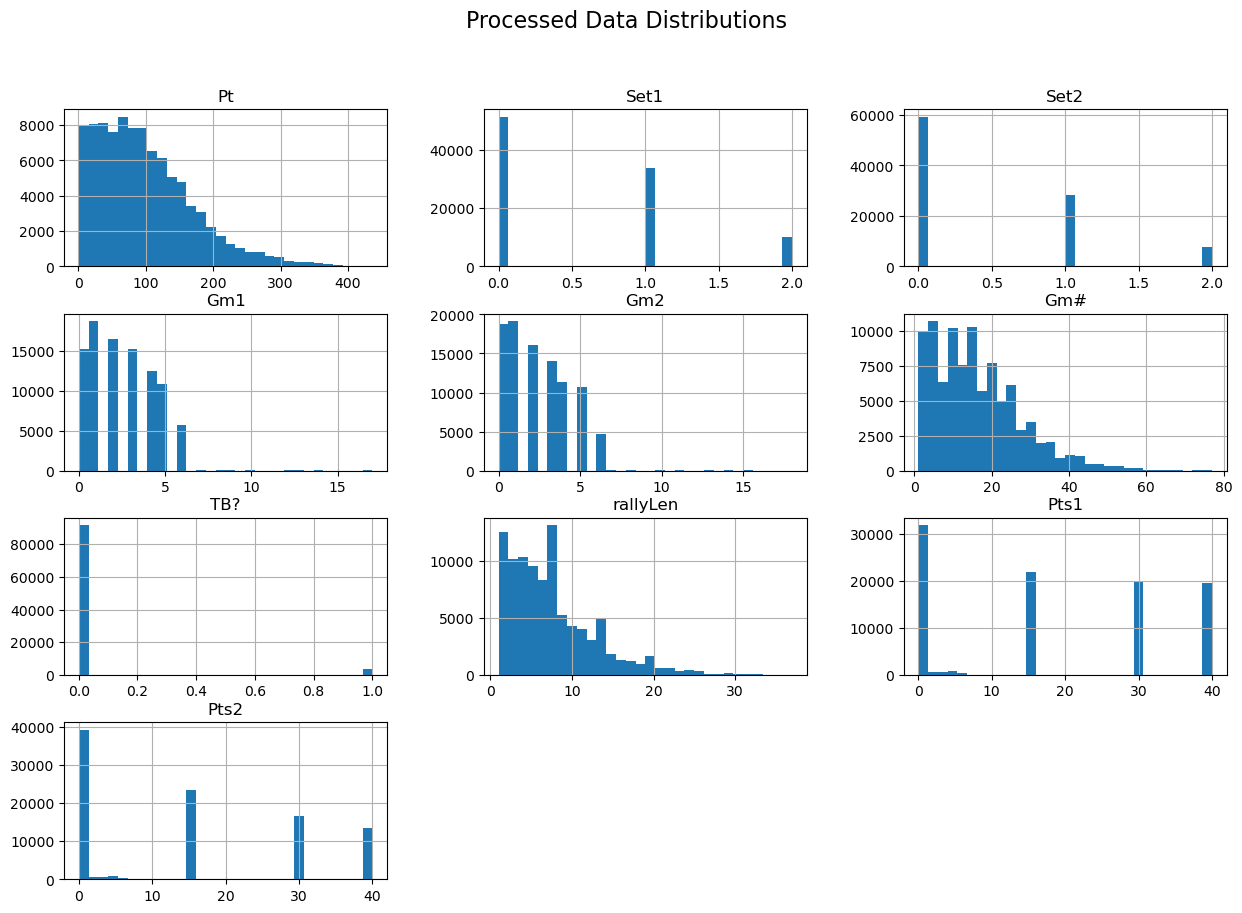

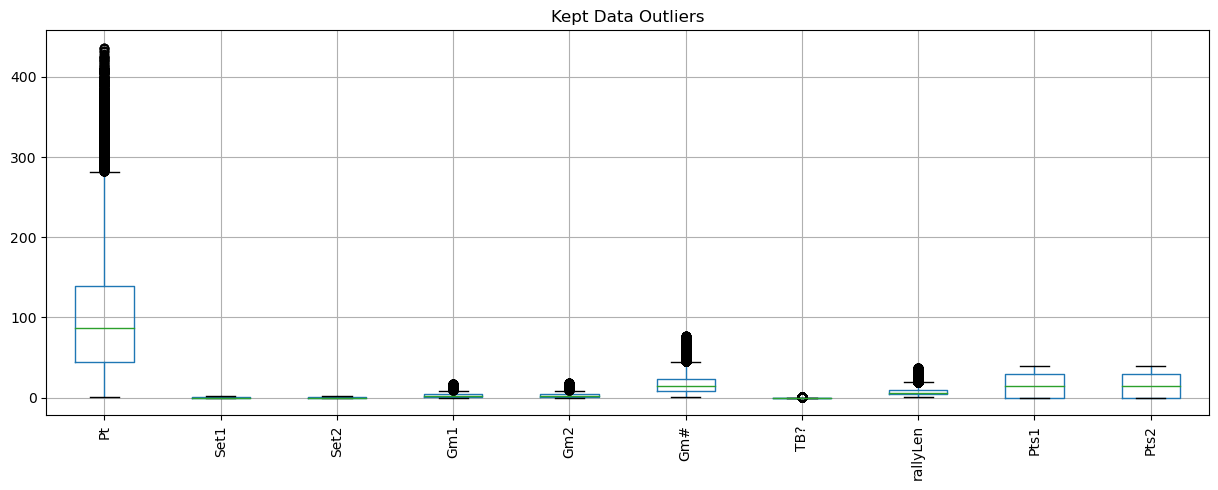


Processed Data Summary Statistics:
                 Pt          Set1          Set2           Gm1           Gm2  \
count  95207.000000  95207.000000  95207.000000  95207.000000  95207.000000   
mean      99.148718      0.567815      0.457067      2.531757      2.365446   
std       71.372170      0.676738      0.638372      1.906700      1.923314   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%       44.000000      0.000000      0.000000      1.000000      1.000000   
50%       87.000000      0.000000      0.000000      2.000000      2.000000   
75%      139.000000      1.000000      1.000000      4.000000      4.000000   
max      436.000000      2.000000      2.000000     17.000000     18.000000   

                Gm#           TB?      rallyLen          Pts1          Pts2  
count  95207.000000  95207.000000  95207.000000  95207.000000  95207.000000  
mean      16.243175      0.039545      7.483305     17.940078     14.632559  
std       11.26765

In [116]:
# Visualize distributions to identify skewness
processed_data.hist(bins=30, figsize=(15, 10))
plt.suptitle("Processed Data Distributions", fontsize=16)
plt.show()

# Visualize outliers using boxplots
plt.figure(figsize=(15, 5))
processed_data.boxplot()
plt.title("Kept Data Outliers")
plt.xticks(rotation=90)
plt.show()

print("\nProcessed Data Summary Statistics:")
print(processed_data.describe())

### Train word embeddings with full dataset
With our model, label encoding has worked better than word embeddings, so we will hide this section

We will first pre-process the full dataset (all players) with the same cleaning process that we need for the Rafael Nadal dataset

In [48]:
# adjust the processing to not take into account Svr, as we are looking at all players
import re
import numpy as np
import pandas as pd

def process_full_rally_data(df, shot_vocab):
    sequence_data = []
    direction_dict = {'1', '2', '3'}
    serve_dict={'4','5','6'}

    for _, row in df.iterrows():
        isServe = row['Svr'] == 1
        rally = str(row['rallyNoError'])

        if pd.isna(rally) or len(rally) < 2:
            continue

        debug_logs = []
        tokens = []

        # First shot: allow 1–2 digits
        match = re.match(r'^([a-zA-Z])(\d+)', rally)
        if not match:
            continue

        first_letter = match.group(1)
        digits = match.group(2)[:2]
        first_token = first_letter + digits[0]

        if first_token in shot_vocab:
            tokens.append(first_token)
        else:
            continue
        idx = len(match.group(0))

        # Extract remaining shots
        while idx + 2 <= len(rally):
            segment = rally[idx:idx+3]
            debug_logs.append(f"[{idx}] Segment: '{segment}'")

            if re.match(r'^[a-zA-Z]\d[a-zA-Z]$', segment):
                token = segment[0] + segment[1]
                debug_logs.append(f"[{idx}] Pattern A: {segment}")

                if token in shot_vocab:
                    tokens.append(token)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid token: {token}")
                    break
                idx += 2

            elif re.match(r'^[a-zA-Z]\d\d$', segment):
                debug_logs.append(f"[{idx}] Pattern B: {segment}")
                token1 = segment[0] + segment[1]
                token2 = segment[0] + segment[2]

                if segment[1] in direction_dict and token1 in shot_vocab:
                    tokens.append(token1)

                elif segment[2] in direction_dict and token2 in shot_vocab:
                    tokens.append(token2)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid tokens: {token1}, {token2}")
                    break
                idx += 3

            elif re.match(r'^[a-zA-Z][a-zA-Z]\d$', segment):
                debug_logs.append(f"[{idx}] Pattern C: {segment}")
                token = segment[1] + segment[2]

                if token in shot_vocab:
                    tokens.append(token)

                else:
                    debug_logs.append(f"[{idx}] ❌ Invalid token: {token}")
                    break
                idx += 3

            else:
                debug_logs.append(f"[{idx}] Pattern D (Fallback): {segment}")

                if idx + 1 < len(rally):
                    ch1, ch2 = rally[idx], rally[idx + 1]
                    token = ch1 + ch2

                    if ch1.isalpha() and ch2 in direction_dict and token in shot_vocab:
                        tokens.append(token)
                        idx += 2

                    else:
                        debug_logs.append(f"[{idx}] ❌ Invalid fallback token: {token}")
                        break
                else:
                    break

        # Skip rallies with invalid parsing
        if any(log.startswith("❌") for log in debug_logs):
            print(f"\n🔍 Invalid rally at row {row.name}: {rally}")
            for log in debug_logs:
                print(log)
            continue

        # --- Serve Logic --- CHANGED FOR FULL RALLY
        serve_tokens = []

        if pd.notna(row['Sv1']) and row['Sv1'][0] in serve_dict:
            serve_tokens.append(row['Sv1'][0])
            
            if pd.notna(row['Sv2']) and row['Sv2'][0] in serve_dict:
                serve_tokens.append(row['Sv2'][0])

            full_rally = serve_tokens + tokens
        else:
            continue  # skip rally if no valid Sv1


        # --- Label Arrays ---
        winner_array = np.zeros(48)
        unforced_array = np.zeros(48)

        final_shot = tokens[-1]
        idx = shot_vocab.get(final_shot, None)
        if idx is not None:
            if row['isRallyWinner']:
                winner_array[idx] += 1
            elif row['isUnforced']:
                unforced_array[idx] += 1

        # --- 3-Shot Sequence Construction ---
        i = 0 if isServe else 1
        while i + 3 < len(full_rally):
            new_row = row.to_dict()
            new_row['shot1'] = full_rally[i]
            new_row['shot2'] = full_rally[i + 1]
            new_row['shot3'] = full_rally[i + 2]
            new_row['shot4'] = full_rally[i + 3]
            new_row['winner_array'] = winner_array.copy()
            new_row['unforced_array'] = unforced_array.copy()
            sequence_data.append(new_row)
            i += 2

    return pd.DataFrame(sequence_data)


In [49]:
import re
import numpy as np
import pandas as pd
import torch

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

processing_full_data = data.copy()

# Print basic stats
print(f"Number of Unique Matches Found: {processing_full_data['match_id'].nunique()}")
print(f"Number of Rows Selected: {len(processing_full_data)}")

if 'rallyLen' in processing_full_data.columns:
    print(f"Sum of Rally Lengths: {processing_full_data['rallyLen'].sum()}")
else:
    print("Column 'rallyLen' not found in the dataset.")

# Process rallies
sequence_full_data = process_rally_data(processing_full_data, shot_vocab=shot_vocab)

# Sample if too large
if len(sequence_full_data) > 500_000:
    sequence_full_data = sequence_full_data.sample(n=500_000, random_state=42)
    print("Sampled down to 500,000 sequences for embedding training.")

# Drop irrelevant columns if defined in processing_features
processed_full_data = sequence_full_data.drop(columns=processing_features, errors='ignore')

# Convert 'Pts' to Pts1 and Pts2
processed_full_data[['Pts1', 'Pts2']] = processed_full_data['Pts'].apply(
    lambda x: pd.Series(split_pts(str(x)))
)
processed_full_data.drop('Pts', axis=1, inplace=True)

# Clean Gm# column
processed_full_data['Gm#'] = processed_full_data['Gm#'].apply(
    lambda x: int(re.match(r'\d+', str(x)).group()) if re.match(r'\d+', str(x)) else 0
)

# Fill missing tiebreak indicator
processed_full_data['TB?'].fillna(0, inplace=True)

# Drop rows with missing game counts
processed_full_data.dropna(subset=['Gm2', 'Gm#'], inplace=True)

# Unpack winner/unforced arrays
winner_df = pd.DataFrame(processed_full_data['winner_array'].tolist(), index=processed_full_data.index)
winner_df.columns = [f'winner_{i}' for i in range(winner_df.shape[1])]
unforced_df = pd.DataFrame(processed_full_data['unforced_array'].tolist(), index=processed_full_data.index)
unforced_df.columns = [f'unforced_{i}' for i in range(unforced_df.shape[1])]

processed_full_data.drop(columns=['winner_array', 'unforced_array'], inplace=True)
processed_full_data = pd.concat([processed_full_data, winner_df, unforced_df], axis=1)
# ---------------------------
# Drop columns not deemed important by XGBoost
# ---------------------------
important_features = set([
    'rallyLen', 'shot3',
    'winner_0', 'winner_1', 'winner_2', 'winner_3', 'winner_4', 'winner_5',
    'winner_12', 'winner_13', 'winner_14', 'winner_15', 'winner_17', 'winner_18',
    'winner_20', 'winner_24', 'winner_26', 'winner_27', 'winner_38', 'winner_42', 'winner_43', 'winner_44',
    'unforced_0', 'unforced_1', 'unforced_2', 'unforced_3', 'unforced_4', 'unforced_5',
    'unforced_9', 'unforced_10', 'unforced_11', 'unforced_12', 'unforced_13', 'unforced_14',
    'unforced_16', 'unforced_17', 'unforced_26', 'unforced_27', 'unforced_29'
])

# Always retain shot1, shot2, shot4 for training and prediction
must_have = {'shot1', 'shot2', 'shot4'}
columns_to_keep = list(important_features.union(must_have))

# Filter only the necessary columns for modeling
filtered_full_data = processed_full_data[[col for col in processed_full_data.columns if col in columns_to_keep]]

print("\n✅ Filtered dataset preview:")
print(filtered_full_data.head())
print("\nRemaining columns:", filtered_full_data.columns.tolist())


Using device: cuda
Number of Unique Matches Found: 2053
Number of Rows Selected: 331720
Sum of Rally Lengths: 1258899


C:\Users\nicho\AppData\Local\Temp\ipykernel_30684\587475941.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_full_data['TB?'].fillna(0, inplace=True)



✅ Filtered dataset preview:
   rallyLen shot1 shot2 shot3 shot4  winner_0  winner_1  winner_2  winner_3  \
0         6     0     6    b1    f2       0.0       0.0       0.0       0.0   
1         6    b1    f2    f1    b1       0.0       0.0       0.0       0.0   
2         6    f1    b1    f1    b1       0.0       0.0       0.0       0.0   
3        15     0     6    f3    f2       0.0       0.0       0.0       0.0   
4        15    f3    f2    f1    b2       0.0       0.0       0.0       0.0   

   winner_4  ...  unforced_10  unforced_11  unforced_12  unforced_13  \
0       0.0  ...          0.0          0.0          0.0          0.0   
1       0.0  ...          0.0          0.0          0.0          0.0   
2       0.0  ...          0.0          0.0          0.0          0.0   
3       0.0  ...          0.0          0.0          0.0          0.0   
4       0.0  ...          0.0          0.0          0.0          0.0   

   unforced_14  unforced_16  unforced_17  unforced_26  unforced

In [50]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 1: Encode shot tokens
shot_encoder = LabelEncoder()
all_shots = pd.concat([processed_full_data['shot1'], processed_full_data['shot2'], processed_full_data['shot3'], processed_full_data['shot4']])
shot_encoder.fit(all_shots.astype(str))

processed_full_data['shot1_enc'] = shot_encoder.transform(processed_full_data['shot1'].astype(str))
processed_full_data['shot2_enc'] = shot_encoder.transform(processed_full_data['shot2'].astype(str))
processed_full_data['shot3_enc'] = shot_encoder.transform(processed_full_data['shot3'].astype(str))
processed_full_data['shot4_enc'] = shot_encoder.transform(processed_full_data['shot4'].astype(str))

num_classes = len(shot_encoder.classes_)

# Step 2: Prepare training tensors
X = processed_full_data[['shot1_enc', 'shot2_enc', 'shot3_enc']].values
y = processed_full_data['shot4_enc'].values

X_tensor = torch.tensor(X, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=128)

# Step 3: Define LSTM model for embedding pretraining
class ShotEmbeddingTrainer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(ShotEmbeddingTrainer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch, 2, emb_dim]
        _, (hn, _) = self.lstm(embedded)  # hn: [1, batch, hidden]
        output = self.fc(hn.squeeze(0))  # [batch, num_classes]
        return output

# Step 4: Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ShotEmbeddingTrainer(
    vocab_size=num_classes,
    embedding_dim=16,
    hidden_size=64,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Step 5: Save the embedding layer
embedding_weights = model.embedding.weight.data.cpu().clone()
torch.save(embedding_weights, "pretrained_shot_embeddings.pt")
print("✅ Saved pretrained embeddings to pretrained_shot_embeddings.pt")


Epoch 1, Loss: 2.1831
Epoch 2, Loss: 2.0734
Epoch 3, Loss: 2.0574
Epoch 4, Loss: 2.0509
Epoch 5, Loss: 2.0472
Epoch 6, Loss: 2.0444
Epoch 7, Loss: 2.0423
Epoch 8, Loss: 2.0407
Epoch 9, Loss: 2.0392
Epoch 10, Loss: 2.0379
✅ Saved pretrained embeddings to pretrained_shot_embeddings.pt


In [51]:
import pickle
with open('shot_encoder.pkl', 'wb') as f:
    pickle.dump(shot_encoder, f)

### RNN Implementation


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNLSTMShotPredictor(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(CNNLSTMShotPredictor, self).__init__()

        self.conv1d = nn.Conv1d(
            in_channels=input_size,   # each feature over time
            out_channels=64,
            kernel_size=2,
            padding=1
        )

        self.lstm = nn.LSTM(
            input_size=64,           # output of conv1d per timestep
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False      # match your best model
        )

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: [B, T, input_size] → [B, input_size, T]
        x = x.permute(0, 2, 1)

        # Apply 1D CNN
        x = self.conv1d(x)          # [B, 64, T]
        x = F.relu(x)

        # Back to [B, T, 64]
        x = x.permute(0, 2, 1)

        # Apply LSTM
        lstm_out, (hidden, _) = self.lstm(x)  # hidden: [num_layers, B, hidden_size]
        final_hidden = hidden[-1]             # [B, hidden_size]
        final_hidden = self.dropout(final_hidden)

        return self.classifier(final_hidden)  # [B, num_classes]


#### Training with pre-trained embeddings - NOT USED, LABEL ENCODING PERFORMED BETTER

In [ ]:
# # training with pre-trained embeddings

# import pandas as pd
# import numpy as np
# import torch
# import pickle
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split

# # --- Define valid rally tokens (exclude serves like '0', '4', '5', '6') ---
# rally_tokens = sorted([tok for tok in shot_vocab.keys() if tok[0] not in {'0', '4', '5', '6'}])
# print(f"Rally vocab size: {len(rally_tokens)}")

# # --- Rebuild LabelEncoder (rally-only) ---
# label_encoder = LabelEncoder()
# label_encoder.classes_ = np.array(rally_tokens)

# # --- Load pretrained encoder and embedding ---
# with open("shot_encoder.pkl", "rb") as f:
#     full_encoder = pickle.load(f)

# pretrained_weights = torch.load("pretrained_shot_embeddings.pt")
# print("Original embedding shape:", pretrained_weights.shape)  # e.g. [52, 16]

# # --- Map rally tokens to original indices and trim embedding ---
# token_to_index = {tok: np.where(full_encoder.classes_ == tok)[0][0] for tok in rally_tokens}
# trimmed_embeddings = torch.stack([pretrained_weights[token_to_index[tok]] for tok in rally_tokens])
# print("Trimmed embedding shape:", trimmed_embeddings.shape)  # Should be [48, 16]

# # --- Preprocess your data ---
# processed_data_rnn = processed_data.copy()

# # Unpack winner/unforced arrays
# winner_df = pd.DataFrame(processed_data_rnn['winner_array'].tolist(), index=processed_data_rnn.index)
# winner_df.columns = [f'winner_{i}' for i in range(winner_df.shape[1])]
# unforced_df = pd.DataFrame(processed_data_rnn['unforced_array'].tolist(), index=processed_data_rnn.index)
# unforced_df.columns = [f'unforced_{i}' for i in range(unforced_df.shape[1])]

# processed_data_rnn.drop(columns=['winner_array', 'unforced_array'], inplace=True)
# processed_data_rnn = pd.concat([processed_data_rnn, winner_df, unforced_df], axis=1)

# # --- Filter out any rows with serve tokens in shot1, shot2, shot3 or shot4 ---
# def is_rally_token(tok):
#     return isinstance(tok, str) and tok[0] not in {'0', '4', '5', '6'}

# mask = (
#     processed_data_rnn['shot1'].apply(is_rally_token) &
#     processed_data_rnn['shot2'].apply(is_rally_token) &
#     processed_data_rnn['shot3'].apply(is_rally_token) &
#     processed_data_rnn['shot4'].apply(is_rally_token)
# )
# processed_data_rnn = processed_data_rnn[mask].copy()

# # --- Encode shots using the new label encoder ---
# processed_data_rnn['shot1'] = label_encoder.transform(processed_data_rnn['shot1'])
# processed_data_rnn['shot2'] = label_encoder.transform(processed_data_rnn['shot2'])
# processed_data_rnn['shot3'] = label_encoder.transform(processed_data_rnn['shot3'])
# processed_data_rnn['shot4'] = label_encoder.transform(processed_data_rnn['shot4'])

# # --- keep xgboost columns only---

# important_features = set([
#     'rallyLen', 'shot3',
#     'winner_0', 'winner_1', 'winner_2', 'winner_3', 'winner_4', 'winner_5',
#     'winner_12', 'winner_13', 'winner_14', 'winner_15', 'winner_17', 'winner_18',
#     'winner_20', 'winner_24', 'winner_26', 'winner_27', 'winner_38', 'winner_42', 'winner_43', 'winner_44',
#     'unforced_0', 'unforced_1', 'unforced_2', 'unforced_3', 'unforced_4', 'unforced_5',
#     'unforced_9', 'unforced_10', 'unforced_11', 'unforced_12', 'unforced_13', 'unforced_14',
#     'unforced_16', 'unforced_17', 'unforced_26', 'unforced_27', 'unforced_29'
# ])

# # Always retain shot1, shot2, shot4 for training and prediction
# must_have = {'shot1', 'shot2', 'shot4'}
# columns_to_keep = list(important_features.union(must_have))

# # Filter only the necessary columns for modeling
# filtered_full_data = processed_full_data[[col for col in processed_full_data.columns if col in columns_to_keep]]

# # --- Define features and target ---
# target = processed_data_rnn['shot4']
# features = processed_data_rnn.drop(columns=['shot4'])

# # Sanity check: target values must be in [0, 47]
# assert target.min() >= 0 and target.max() < len(rally_tokens), "Target labels out of bounds"

# # --- Build sequences: [shot1 + context], [shot2 + context] ---
# context_cols = [col for col in features.columns if col not in ['shot1', 'shot2', 'shot3']]
# X_sequences = []

# for _, row in features.iterrows():
#     context = row[context_cols].values.astype(np.float32)
#     shot1 = np.insert(context, 0, row['shot1'])
#     shot2 = np.insert(context, 0, row['shot2'])
#     shot3 = np.insert(context, 0, row['shot3'])
#     X_sequences.append(np.stack([shot1, shot2, shot3]))

# # --- Normalize the features ---
# X_array = np.array(X_sequences).reshape(-1, X_sequences[0].shape[1])
# scaler = StandardScaler()
# X_scaled_flat = scaler.fit_transform(X_array)
# X_scaled = X_scaled_flat.reshape(len(X_sequences), 3, -1)

# # --- Convert to torch tensors ---
# X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
# y_tensor = torch.tensor(target.values, dtype=torch.long)

# # --- Train/test split ---
# # Split train further into train + val (e.g., 60% train, 20% val, 20% test)
# X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# # --- Save the encoder and embeddings for model use ---
# with open("trimmed_shot_encoder.pkl", "wb") as f:
#     pickle.dump(label_encoder, f)

# torch.save(trimmed_embeddings, "trimmed_shot_embeddings.pt")

# print("✅ Preprocessing complete.")
# print("Train shape:", X_train.shape, "Target shape:", y_train.shape)
# print("Num classes:", len(label_encoder.classes_))


Rally vocab size: 48
Original embedding shape: torch.Size([52, 16])
Trimmed embedding shape: torch.Size([48, 16])


C:\Users\nicho\AppData\Local\Temp\ipykernel_30684\3645131874.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load("pretrained_shot_embeddings

✅ Preprocessing complete.
Train shape: torch.Size([28625, 3, 107]) Target shape: torch.Size([28625])
Num classes: 48


#### Training using label encoding

In [28]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle

# --- Step 1: Copy the original data ---
processed_data_rnn = processed_data.copy()

# --- Step 2: Unpack winner and unforced arrays ---
winner_df = pd.DataFrame(processed_data_rnn['winner_array'].tolist(), index=processed_data_rnn.index)
winner_df.columns = [f'winner_{i}' for i in range(winner_df.shape[1])]
unforced_df = pd.DataFrame(processed_data_rnn['unforced_array'].tolist(), index=processed_data_rnn.index)
unforced_df.columns = [f'unforced_{i}' for i in range(unforced_df.shape[1])]
processed_data_rnn.drop(columns=['winner_array', 'unforced_array'], inplace=True)
processed_data_rnn = pd.concat([processed_data_rnn, winner_df, unforced_df], axis=1)

# --- Step 3: Filter out serve tokens from shot4 only ---
def is_rally(tok):
    return isinstance(tok, str) and tok[0] not in {'0', '4', '5', '6'}

processed_data_rnn = processed_data_rnn[processed_data_rnn['shot4'].apply(is_rally)].copy()

# --- Step 4: Refit LabelEncoder ONLY on shot1-4 after shot4 filtering ---
all_shots = pd.concat([
    processed_data_rnn['shot1'],
    processed_data_rnn['shot2'],
    processed_data_rnn['shot3'],
    processed_data_rnn['shot4']
]).astype(str)

label_encoder = LabelEncoder()
label_encoder.fit(all_shots)

# Save the encoder
with open("label_encoder_full.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# --- Step 5: Encode all shots ---
for col in ['shot1', 'shot2', 'shot3', 'shot4']:
    processed_data_rnn[col] = label_encoder.transform(processed_data_rnn[col].astype(str))

# --- Step 6: Keep only XGBoost-important features + shot1, shot2, shot3 ---
important_features = set([
    'rallyLen', 'shot3',
    'winner_0', 'winner_1', 'winner_2', 'winner_3', 'winner_4', 'winner_5',
    'winner_12', 'winner_13', 'winner_14', 'winner_15', 'winner_17', 'winner_18',
    'winner_20', 'winner_24', 'winner_26', 'winner_27', 'winner_38', 'winner_42', 'winner_43', 'winner_44',
    'unforced_0', 'unforced_1', 'unforced_2', 'unforced_3', 'unforced_4', 'unforced_5',
    'unforced_9', 'unforced_10', 'unforced_11', 'unforced_12', 'unforced_13', 'unforced_14',
    'unforced_16', 'unforced_17', 'unforced_26', 'unforced_27', 'unforced_29'
])
required_shots = {'shot1', 'shot2', 'shot3', 'shot4'}
columns_to_keep = list(important_features.union(required_shots))

processed_data_rnn = processed_data_rnn[[col for col in processed_data_rnn.columns if col in columns_to_keep]]

# --- Step 7: Define target and features ---
target = processed_data_rnn['shot4']
features = processed_data_rnn.drop(columns=['shot4'])

# --- Step 8: Build 3-shot input sequences ---
context_cols = [col for col in features.columns if col not in ['shot1', 'shot2', 'shot3']]
X_sequences = []

for _, row in features.iterrows():
    context = row[context_cols].values.astype(np.float32)
    shot1 = np.insert(context, 0, row['shot1'])
    shot2 = np.insert(context, 0, row['shot2'])
    shot3 = np.insert(context, 0, row['shot3'])
    X_sequences.append(np.stack([shot1, shot2, shot3]))

# --- Step 9: Normalize features ---
X_array = np.array(X_sequences).reshape(-1, X_sequences[0].shape[1])
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_array)
X_scaled = X_scaled_flat.reshape(len(X_sequences), 3, -1)

# --- Step 10: Convert to tensors ---
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(target.values, dtype=torch.long)

# --- Step 11: Train/Val/Test Split (60/20/20) ---
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

print("✅ Final preprocessing complete.")
print(f"Train shape: {X_train.shape} — Target shape: {y_train.shape}")
print(f"Num classes in encoder: {len(label_encoder.classes_)} — Unique labels in target: {len(np.unique(y_train.numpy()))}")


✅ Final preprocessing complete.
Train shape: torch.Size([50445, 3, 39]) — Target shape: torch.Size([50445])
Num classes in encoder: 52 — Unique labels in target: 47


In [29]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from collections import Counter 

train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = CNNLSTMShotPredictor(
    num_classes=len(label_encoder.classes_),
    input_size=X_train.shape[2],
    hidden_size=64,
    num_layers=1
).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0007, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

# Training loop
num_epochs = 100

best_val_acc = 0
patience = 15
patience_counter = 0

min_delta = 0.001  # minimum improvement to reset patience
best_val_loss = float('inf')  # initialize with infinity

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    # --- Evaluate on train set ---
    model.eval()
    correct_train = 0
    total_train = 0

    with torch.no_grad():
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

    train_acc = correct_train / total_train
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # --- Evaluate on validation set ---
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val
    print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

    # --- Early stopping with min_delta ---
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"⛔ Early stopping triggered. Best validation loss: {best_val_loss:.4f}")
            break




Epoch [1/100], Loss: 2.4174, Train Accuracy: 0.3053
Validation Accuracy: 0.3024, Validation Loss: 2.2415
Epoch [2/100], Loss: 2.2234, Train Accuracy: 0.3164
Validation Accuracy: 0.3164, Validation Loss: 2.1966
Epoch [3/100], Loss: 2.1848, Train Accuracy: 0.3164
Validation Accuracy: 0.3164, Validation Loss: 2.1700
Epoch [4/100], Loss: 2.1586, Train Accuracy: 0.3203
Validation Accuracy: 0.3217, Validation Loss: 2.1418
Epoch [5/100], Loss: 2.1342, Train Accuracy: 0.3235
Validation Accuracy: 0.3264, Validation Loss: 2.1242
Epoch [6/100], Loss: 2.1116, Train Accuracy: 0.3315
Validation Accuracy: 0.3285, Validation Loss: 2.1136
Epoch [7/100], Loss: 2.0920, Train Accuracy: 0.3374
Validation Accuracy: 0.3335, Validation Loss: 2.0843
Epoch [8/100], Loss: 2.0725, Train Accuracy: 0.3400
Validation Accuracy: 0.3358, Validation Loss: 2.0642
Epoch [9/100], Loss: 2.0573, Train Accuracy: 0.3387
Validation Accuracy: 0.3332, Validation Loss: 2.0543
Epoch [10/100], Loss: 2.0417, Train Accuracy: 0.3463
Va

In [31]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.4031
